In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import pacf,acf
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy import stats
from statsmodels.tools.eval_measures import rmse

In [2]:
# taken from https://www.statsmodels.org/devel/examples/notebooks/generated/stationarity_detrending_adf_kpss.html
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [3]:
sns.set()

In [4]:
wd=os.getcwd()
wd

'C:\\Users\\iavta\\Time Series'

In [5]:
path_to_data=r"C:\Users\iavta\Time Series\R Datasets\Rdatasets-master\csv\datasets"
df=pd.read_csv(path_to_data+r"\AirPassengers.csv",index_col="time",parse_dates=True)

In [6]:
df.head()

,Unnamed: 0,value
time,,
1949-01-01,1,112
1949-01-01,2,118
1949-01-01,3,132
1949-01-01,4,129
1949-01-01,5,121


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-01-01
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Unnamed: 0  144 non-null    int64
 1   value       144 non-null    int64
dtypes: int64(2)
memory usage: 3.4 KB


In [8]:
df.drop(["Unnamed: 0"],axis=1, inplace=True)

In [9]:
time=pd.date_range("1949-01-01","1960-12-01",freq="MS")
df.index=time

In [10]:
df.rename(columns={"value":"NumPassengers"},inplace=True)
df.head()

,NumPassengers
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   NumPassengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


## Ploting Original Data

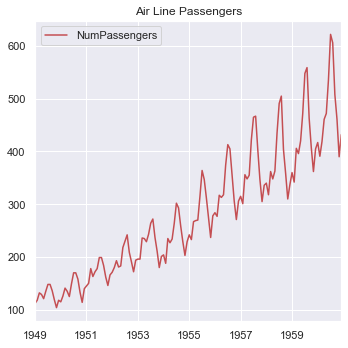

In [12]:
df.plot(kind='line', title="Air Line Passengers",
        layout=(4, 1), legend=True,    
        style=['r'], figsize=(5,5))
plt.tight_layout()
plt.show;

# Plotting Transformed Data (Weak Stationarity)

### Differencing

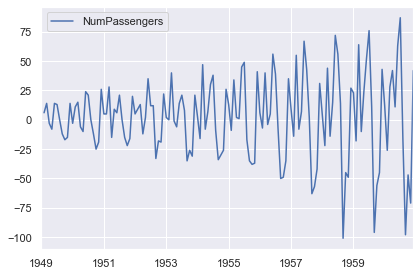

In [13]:
df_dif=df.diff()
df_dif.rename(columns={"value":"NumPassengers"},inplace=True)
df_dif.plot()
plt.tight_layout()
plt.show;

The Variance is not time independent, so, differencing is not enough...
We need to apply a transformation that affects the variance, like Box-Cox, or log.

## Box-Cox Data

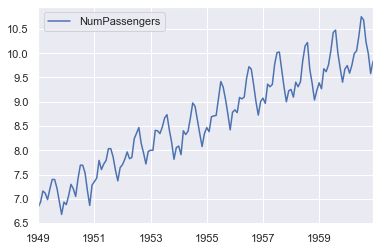

In [14]:
df_box_cox=pd.DataFrame()
Box_Cox_data, lambda_par =stats.boxcox(df["NumPassengers"].values)
df_box_cox["NumPassengers"]= Box_Cox_data
df_box_cox.index=time
df_box_cox.plot();

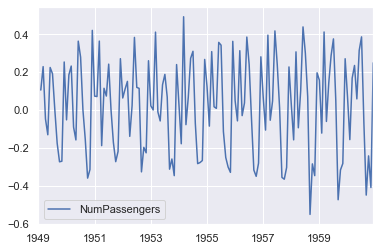

In [15]:
df_boxcox_dif=df_box_cox.diff()
df_boxcox_dif.rename(columns={"value":"NumPassengers"},inplace=True)
df_boxcox_dif.plot()
plt.show;

In [16]:
df_boxcox_dif.dropna(inplace=True)
adf_test(df_boxcox_dif)

Results of Dickey-Fuller Test:
Test Statistic                  -2.871708
p-value                          0.048738
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


At 5% we reject the null(unit root). But let's see if we can improve the p-value.

In [17]:
df_boxcox_dif_dif12=df_boxcox_dif.diff(periods=12).dropna()
adf_test(df_boxcox_dif_dif12)

Results of Dickey-Fuller Test:
Test Statistic                  -4.393873
p-value                          0.000304
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


Now, we get to reject the null at 1%!

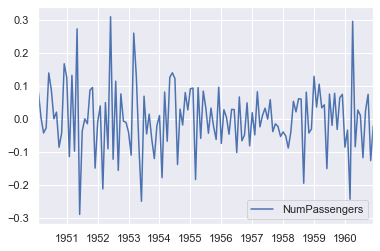

In [18]:
df_boxcox_dif_dif12.plot();

In [19]:
# partial autocorrelation function
# partial_acf_boxcox=pacf(df_boxcox_dif_dif12,nlags=len(df_boxcox_dif_dif12.values)//2-1)
# number of lags has to be < 50%*len(data)

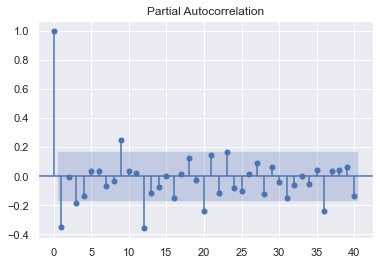

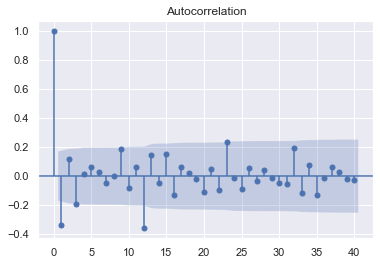

In [38]:
# Plot of Partial AutoCorrelation Function
tsaplots.plot_pacf(df_boxcox_dif_dif12,lags=40);
#plot autocorrelation function
tsaplots.plot_acf(df_boxcox_dif_dif12,lags=40);

ARMA models (including both AR and MA terms) have ACFs and PACFs that both tail off to 0. These are the trickiest because the order will not be particularly obvious. Basically you just have to guess that one or two terms of each type may be needed and then see what happens when you estimate the model.

### Model Building

#### Non-Seasonal
In both graphs, they seem to tail off, which is consistant with an ARMA(1,1)

#### Seasonal
Here, we seem to be tailing off at the seasonal part as well. Hence, we could try a seasonal ARMA(1,1) also.


Note: The PACF of an AR($p$) process cuts to zero after order $p$. 
For a MA, and ARMA, this will slowly dwindle, since MA can be represented as an infinite AR.

Note: The ACF of an MA($\theta$) process cuts to zero after order $\theta$. Similarly, for an ARMA, this will tail off.

Note: The Partial Autocorrelation Function (PACF) - Recall that if $X$, $Y$, and $Z$ are random variables, then the partial correlation between $X$ and $Y$ given $Z$ is obtained by regressing $X$ on $Z$ to obtain $\hat{X}$, regressing $Y$ on $Z$ to obtain $\hat{Y}$, and then calculating
$\rho_{XY|Z} = \text{corr}(X − \hat{X}, Y − \hat{Y})$.
The idea is that $\rho_{XY|Z}$ measures the correlation between X and Y with the linear
effect of Z removed (or partialled out).The PACF, $\phi_{hh}$, is the correlation between $X_{t+h}$ and $X_t$ with the linear dependence of $\{X_{t+1}, . . ., X_{t+h−1}\}$ on each, removed.

So, for the deseasoned detrended box-cox data, we could try a SARIMA$(1,1,1)\times(1,1,1)_{12}$.

In [41]:
model_boxcox=SARIMAX(df_box_cox,order=(1,1,1),seasonal_order =(1, 1, 1, 12))
result_boxcox=model_boxcox.fit()
result_boxcox.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      NumPassengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 137.265
Date:                            Tue, 30 Nov 2021   AIC                           -264.530
Time:                                    09:38:19   BIC                           -250.154
Sample:                                01-01-1949   HQIC                          -258.688
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1490      0.228      0.654      0.513      -0.298       0.596
ma.L1         -0.5335      0.196     -2.718      0.007      -0.918      -0.149
ar.S.L12      -0.1247      0.214     -0.584      0.559      -0.543       0.294
ma.S.L12      -0.4148      0.232     -1.785      0.074      -0.870       0.041
sigma2         0.0070      0.001      8.367      0.000       0.005       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 1.38
Prob(Q):                              0.90   Prob(JB):                         0.50
Heteroskedasticity (H):               0.79   Skew:                             0.07
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The seasonal and non-seasonal AR lags don't seem to be significant. Let's remove them.

In [48]:
model_boxcox_2=SARIMAX(df_box_cox,order=(0,1,1),seasonal_order =(0, 1, 1, 12))
result_boxcox_2=model_boxcox.fit()
result_boxcox_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      NumPassengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 136.845
Date:                            Tue, 30 Nov 2021   AIC                           -267.689
Time:                                    09:39:39   BIC                           -259.064
Sample:                                01-01-1949   HQIC                          -264.184
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3818      0.071     -5.403      0.000      -0.520      -0.243
ma.S.L12      -0.4995      0.096     -5.198      0.000      -0.688      -0.311
sigma2         0.0071      0.001      8.713      0.000       0.005       0.009
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.92
Prob(Q):                              0.91   Prob(JB):                         0.63
Heteroskedasticity (H):               0.74   Skew:                             0.09
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\iavta\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


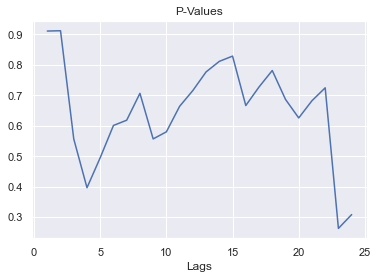

In [49]:
res_LJB_boxcox=result_boxcox_2.test_serial_correlation("ljungbox")
#test_statistics=res_LJB[0,0]
p_values_boxcox=res_LJB_boxcox[0,1]

# An array with (test_statistic, pvalue) for each endogenous variable and each lag. 
# The array is then sized (k_endog, 2, lags).


plt.title("P-Values")
plt.xlabel("Lags")
plt.plot(np.arange(1,len(p_values_boxcox)+1),p_values_boxcox);

The P-values seem too high to reject the null of iid. Hence, we're good! :)

## Log Data

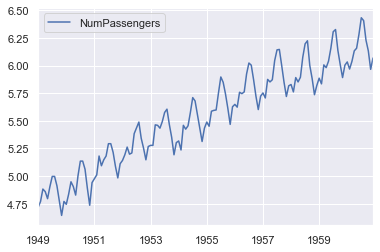

In [50]:
df_log=pd.DataFrame()
df_log["NumPassengers"]= np.log(df["NumPassengers"].values)
df_log.index=time
df_log.plot();

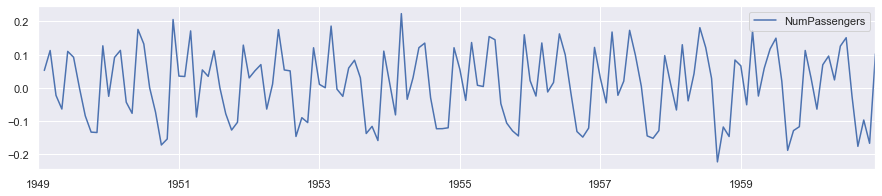

In [51]:
df_log_dif=df_log.diff(periods=1)
df_log_dif.rename(columns={"value":"NumPassengers"},inplace=True)
df_log_dif.plot(figsize=(15,3))
plt.show;

In [52]:
df_log_dif.dropna(inplace=True)
adf_test(df_log_dif)

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


We don't reject the null hypothesis of unit root at 5%, hence, we still need to difference the time series. But the times series seems to be (trend) stationary.

In [53]:
kpss_test(df_log_dif)

Results of KPSS Test:
Test Statistic           0.038304
p-value                  0.100000
Lags Used                6.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


C:\Users\iavta\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Based upon the p-value of KPSS test, we don't reject the null hypothesis (trend-stationarity). 
From checking the plot, this is what one would expect. Hence, from the DF test, we're probably in the presence of seasonality, or some other kind of difference non-stationarity.


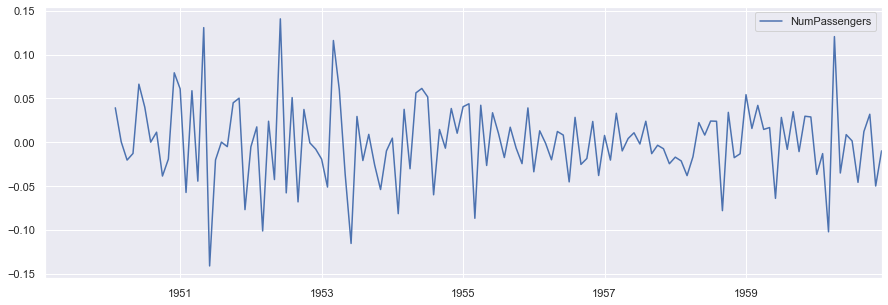

In [54]:
df_log_dif_dif12=df_log_dif.diff(periods=12)
df_log_dif_dif12.plot(figsize=(15,5));

In [55]:
df_log_dif_dif12.dropna(inplace=True)
adf_test(df_log_dif_dif12)

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


After de-seasonalizing, we reject the null at the 5%, hence the data is now difference stationary.

In [56]:
df_log_dif_dif12.shape

(131, 1)

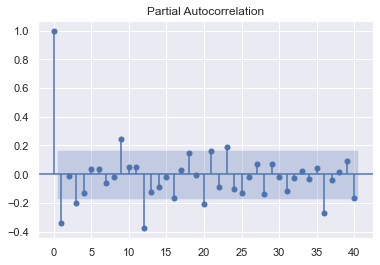

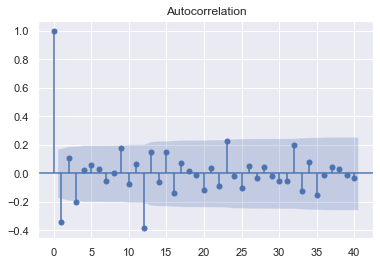

In [59]:
tsaplots.plot_pacf(df_log_dif_dif12,lags=40);
tsaplots.plot_acf(df_log_dif_dif12,lags=40);

### Model Building

Very similar to the Box-Cox'ed data...

#### Non-Seasonal
In both graphs, they seem to tail off, which is consistant with an ARMA(1,1)

#### Seasonal
Here, we seem to be tailing off at the seasonal part as well. Hence, we could try a seasonal ARMA(1,1) also.

So, for the deseasoned detrended log data, we could try a SARIMA$(1,1,1)\times(1,1,1)_{12}$.

In [60]:
model_log=SARIMAX(df_log,order=(1,1,1),seasonal_order =(1, 1, 1, 12))
result_log_1=model_log.fit()
result_log_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      NumPassengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 245.147
Date:                            Tue, 30 Nov 2021   AIC                           -480.295
Time:                                    09:52:06   BIC                           -465.919
Sample:                                01-01-1949   HQIC                          -474.453
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1755      0.212      0.828      0.408      -0.240       0.591
ma.L1         -0.5693      0.183     -3.109      0.002      -0.928      -0.210
ar.S.L12      -0.0851      0.198     -0.430      0.667      -0.473       0.303
ma.S.L12      -0.5081      0.210     -2.418      0.016      -0.920      -0.096
sigma2         0.0013      0.000      8.456      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.57
Prob(Q):                              0.91   Prob(JB):                         0.17
Heteroskedasticity (H):               0.61   Skew:                            -0.01
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Let's remove the non-significant AR terms.

In [63]:
model_log=SARIMAX(df_log,order=(0,1,1),seasonal_order =(0, 1, 1, 12))
result_log_2=model_log.fit()
result_log_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                      NumPassengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                            Tue, 30 Nov 2021   AIC                           -483.393
Time:                                    09:52:55   BIC                           -474.767
Sample:                                01-01-1949   HQIC                          -479.888
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4018      0.073     -5.503      0.000      -0.545      -0.259
ma.S.L12      -0.5570      0.096     -5.785      0.000      -0.746      -0.368
sigma2         0.0013      0.000      9.122      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 1.90
Prob(Q):                              0.84   Prob(JB):                         0.39
Heteroskedasticity (H):               0.58   Skew:                             0.02
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\iavta\anaconda3\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3220: FutureWarning: The default value of lags is changing.  After 0.12, this value will become min(10, nobs//5) for non-seasonal time series and min (2*m, nobs//5) for seasonal time series. Directly set lags to silence this warning.
  warnings.warn(


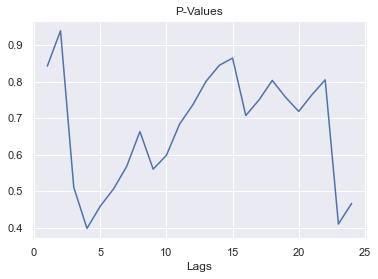

In [64]:
res_LJB=result_log_2.test_serial_correlation("ljungbox")
#test_statistics=res_LJB[0,0]
p_values=res_LJB[0,1]

plt.title("P-Values")
plt.xlabel("Lags")
plt.plot(np.arange(1,len(p_values)+1),p_values);

We never reject all the null hypthesis of (finite var iid sequence =>) the test statistic following a chi-squared distribution, with deg.freedom  =  to size of the sequence.

In [55]:
res_LJB.shape

(1, 2, 24)

# Forecasting

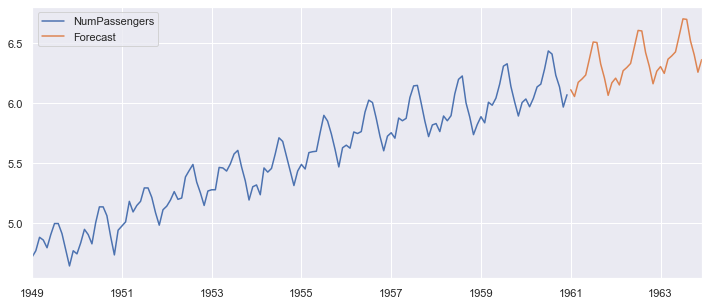

In [70]:
forecast = result_log_2.predict(start = len(df_log),
                                   end = (len(df)-1) + 3 * 12).rename('Forecast')
  
# Plot the forecast values 
# Don't forget to either used the logged data, or apply the inverse function.
df_log.plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True);

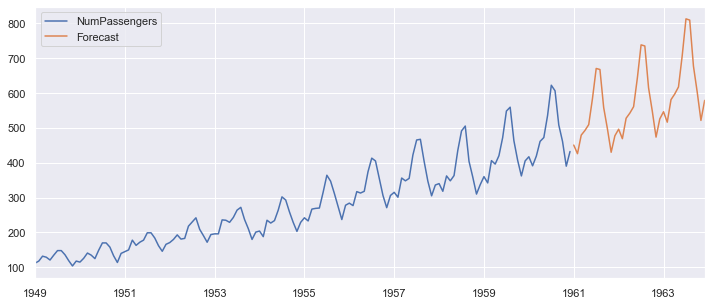

In [71]:
# Don't forget to either used the logged data, or apply the inverse function.
df.plot(figsize = (12, 5), legend = True)
forecast.apply(np.exp).plot(legend = True);

We could have computed the rmse for predictions of the model.
In that case, we should have proceed in the following way:
* Divide the dataset in a train and test set.
* Stationarise the training data
* Plot PACF, ACF for the training data
* Estimate the models on the training data.
* Compute the rmse for the predictions(1-lag, 2-lag, and so on) on the *test* set.